In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# ------------------ SETTINGS ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_img_dir = r"C:\Users\nshre\OneDrive\Desktop\Deep_Vision\Dataset\crowd\part_A\test_data\processed_images"
test_density_dir = r"C:\Users\nshre\OneDrive\Desktop\Deep_Vision\Dataset\crowd\part_A\test_data\processed_density"

# ------------------ CSRNet (fresh, untrained) ------------------
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        # Frontend (VGG-like)
        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True)
        )

        # Backend
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# ------------------ DATASET CLASS ------------------
class CrowdDataset(Dataset):
    def __init__(self, img_dir, density_dir):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        density_path = os.path.join(self.density_dir, img_name.replace(".jpg", ".npy"))

        img = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)/255.0
        density = np.load(density_path).astype(np.float32)

        img = torch.tensor(img).permute(2,0,1)  # C,H,W
        density = torch.tensor(density).unsqueeze(0)  # 1,H,W

        return img, density, img_name

# ------------------ LOAD MODEL ------------------
model = CSRNet().to(device)
model.eval()  # evaluation mode

# ------------------ DATA LOADER ------------------
test_dataset = CrowdDataset(test_img_dir, test_density_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ------------------ TESTING LOOP ------------------
mae = 0.0
mse = 0.0

for images, gts, img_names in test_loader:
    images = images.to(device)
    gts = gts.to(device)

    with torch.no_grad():
        outputs = model(images)

    pred_count = outputs.sum().item()
    gt_count = gts.sum().item()

    mae += abs(pred_count - gt_count)
    mse += (pred_count - gt_count) ** 2

    print(f"{img_names[0]} | Predicted: {pred_count:.2f}, Ground Truth: {gt_count:.2f}")

# ------------------ METRICS ------------------
num_images = len(test_loader)
mae /= num_images
rmse = (mse / num_images) ** 0.5

print(f"\nTest Results - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


IMG_1.jpg | Predicted: 152.71, Ground Truth: 172.00
IMG_10.jpg | Predicted: 166.58, Ground Truth: 502.00
IMG_100.jpg | Predicted: 77.54, Ground Truth: 389.00
IMG_101.jpg | Predicted: 156.18, Ground Truth: 211.00
IMG_102.jpg | Predicted: 26.39, Ground Truth: 223.00
IMG_103.jpg | Predicted: 144.05, Ground Truth: 430.00
IMG_104.jpg | Predicted: 147.52, Ground Truth: 1175.00
IMG_105.jpg | Predicted: 142.32, Ground Truth: 265.00
IMG_106.jpg | Predicted: 100.07, Ground Truth: 1232.00
IMG_107.jpg | Predicted: 66.56, Ground Truth: 289.00
IMG_108.jpg | Predicted: 119.79, Ground Truth: 181.00
IMG_109.jpg | Predicted: 147.52, Ground Truth: 379.00
IMG_11.jpg | Predicted: 147.52, Ground Truth: 1068.00
IMG_110.jpg | Predicted: 147.52, Ground Truth: 1021.00
IMG_111.jpg | Predicted: 147.52, Ground Truth: 452.00
IMG_112.jpg | Predicted: 146.43, Ground Truth: 256.00
IMG_113.jpg | Predicted: 109.40, Ground Truth: 66.00
IMG_114.jpg | Predicted: 166.58, Ground Truth: 141.00
IMG_115.jpg | Predicted: 51.65, 

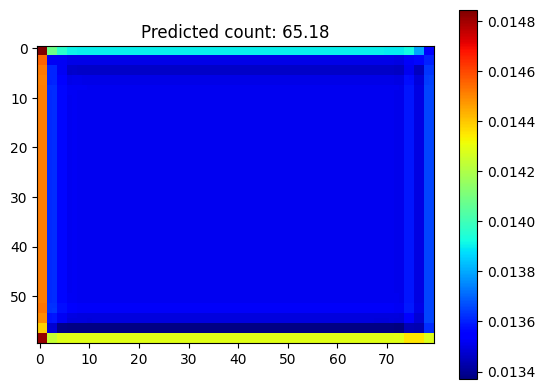

In [3]:
import matplotlib.pyplot as plt

# Assuming 'outputs' is the predicted density map
density_map = outputs.squeeze().cpu().numpy()
plt.imshow(density_map, cmap='jet')
plt.title(f"Predicted count: {density_map.sum():.2f}")
plt.colorbar()
plt.show()
